In [2]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
train = pd.read_csv('trains.csv')
test = pd.read_csv('test.csv')

for col in train.columns:
    col_type = train[col].dtypes
    min1 = train[col].min()
    max1 = train[col].max()
    if str(col_type)[:3] == 'int':
        train[col] = train[col].astype(np.int16)
    else:
        if min1 > np.finfo(np.float16).min and max1 < np.finfo(np.float16).max:
            train[col] = train[col].astype(np.float16)
        elif min1 > np.finfo(np.float32).min and max1 < np.finfo(np.float32).max:
            train[col] = train[col].astype(np.float32)
        else:
            train[col] = train[col].astype(np.float64)
train_X = train.iloc[:,4:]
train_Y = train.iloc[:,0:4]
test_X = test.iloc[:,1:]

In [3]:
from sklearn.preprocessing import MinMaxScaler
xscaler = MinMaxScaler()
yscaler = MinMaxScaler()
scaler_y = yscaler.fit_transform(train_Y)
scaler_x = xscaler.fit_transform(train_X)

In [4]:
import keras
from keras.layers.recurrent import GRU
from keras.models import Sequential, Model
from keras.layers import *
from keras import optimizers
from keras import activations
def build_model():
    model = Sequential()
    model.add(Dense(units=226, activation='relu', input_dim=226))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(units=168, activation='relu'))
    model.add(Dense(units=168, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=50, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=4, activation='linear'))
    op = optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='mae', optimizer=op, metrics=['mae'])
    return model

In [5]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import keras.backend as K
class LRFinder(Callback):
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')

In [6]:
epochs = 100
batch_size = 1000
epoch_size = len(train_X)

lr_finder = LRFinder(min_lr=1e-3, 
                     max_lr=1e-2, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)

early_stop = keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

ckpt_dir = './ckpt'
ckpt_path = ckpt_dir + '/ResNetFinetuning_{epoch:02d}_valloss{val_loss:.2f}.hdf5'
ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

In [8]:
model11 = build_model()
model11.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 226)               51302     
_________________________________________________________________
batch_normalization_1 (Batch (None, 226)               904       
_________________________________________________________________
dense_2 (Dense)              (None, 168)               38136     
_________________________________________________________________
dense_3 (Dense)              (None, 168)               28392     
_________________________________________________________________
batch_normalization_2 (Batch (None, 168)               672       
_________________________________________________________________
dense_4 (Dense)              (None, 100)               16900     
_________________________________________________________________
dense_5 (Dense)              (None, 100)              

In [9]:
model11 = build_model()
model11.fit(scaler_x, scaler_y, epochs=100,callbacks=[ckpt, lr_finder], batch_size=500, validation_split = 0.1,shuffle=True)

Train on 729000 samples, validate on 81000 samples
Epoch 1/100
729000/729000 [==============================] - 41s 56us/step - loss: 0.1652 - mae: 0.1652 - val_loss: 0.2255 - val_mae: 0.2255
Epoch 2/100
729000/729000 [==============================] - 19s 27us/step - loss: 0.0988 - mae: 0.0988 - val_loss: 0.1780 - val_mae: 0.1780
Epoch 3/100
729000/729000 [==============================] - 20s 27us/step - loss: 0.0757 - mae: 0.0757 - val_loss: 0.1621 - val_mae: 0.1621
Epoch 4/100
729000/729000 [==============================] - 19s 26us/step - loss: 0.0627 - mae: 0.0627 - val_loss: 0.1533 - val_mae: 0.1533
Epoch 5/100
729000/729000 [==============================] - 19s 27us/step - loss: 0.0547 - mae: 0.0547 - val_loss: 0.1542 - val_mae: 0.1542
Epoch 6/100
729000/729000 [==============================] - 19s 27us/step - loss: 0.0491 - mae: 0.0491 - val_loss: 0.1377 - val_mae: 0.1377
Epoch 7/100
729000/729000 [==============================] - 19s 27us/step - loss: 0.0450 - mae: 0.0450

729000/729000 [==============================] - 20s 28us/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.1045 - val_mae: 0.1045
Epoch 59/100
729000/729000 [==============================] - 20s 27us/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.1055 - val_mae: 0.1055
Epoch 60/100
729000/729000 [==============================] - 20s 27us/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.1033 - val_mae: 0.1033
Epoch 61/100
729000/729000 [==============================] - 20s 28us/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0923 - val_mae: 0.0923
Epoch 62/100
729000/729000 [==============================] - 20s 27us/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.1042 - val_mae: 0.1042
Epoch 63/100
729000/729000 [==============================] - 20s 28us/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.1074 - val_mae: 0.1074
Epoch 64/100
729000/729000 [==============================] - 20s 27us/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0956 - val_mae: 0.0956
Epoch 65/100
729000

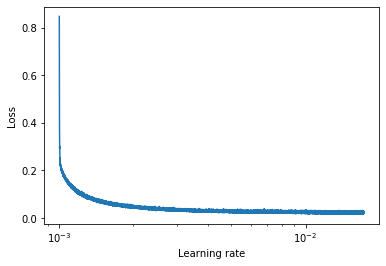

In [10]:
lr_finder.plot_loss()

In [18]:
model11.load_weights(ckpt_dir +'/ResNetFinetuning_61_valloss0.09.hdf5')
pred_test = model11.predict(xscaler.transform(test_X))
y_pred1 = yscaler.inverse_transform(pred_test)
model11.load_weights(ckpt_dir +'/ResNetFinetuning_54_valloss0.09.hdf5')
pred_test = model11.predict(xscaler.transform(test_X))
y_pred2 = yscaler.inverse_transform(pred_test)
model11.load_weights(ckpt_dir +'/ResNetFinetuning_75_valloss0.09.hdf5')
pred_test = model11.predict(xscaler.transform(test_X))
y_pred3 = yscaler.inverse_transform(pred_test)
model11.load_weights(ckpt_dir +'/ResNetFinetuning_100_valloss0.09.hdf5')
pred_test = model11.predict(xscaler.transform(test_X))
y_pred4 = yscaler.inverse_transform(pred_test)

In [21]:
y_pred = (y_pred1+y_pred2+y_pred3+y_pred4)/4

In [22]:
sample = pd.read_csv("sample_submission.csv")
sample.iloc[:,1:] = y_pred
sample.head()

,id,layer_1,layer_2,layer_3,layer_4
0,0,255.740845,227.340714,132.363541,87.203773
1,1,155.225677,133.928009,229.994293,99.849365
2,2,146.288162,184.607651,270.082306,160.962891
3,3,92.003288,223.876953,191.311127,79.020134
4,4,267.545288,290.570435,242.225510,268.157135


In [23]:
sample.to_csv("sample_sub1.csv",index=False)